# Libraries

In [680]:
if(!require(ggplot2)) {
  install.packages("ggplot2", repos="http://cloud.r-project.org")
  require(ggplot2)
}
if(!require(gridExtra)) {
  install.packages("gridExtra", repos="http://cloud.r-project.org")
  require(gridExtra)
}
if(!require(lubridate)) {
  install.packages("lubridate", repos="http://cloud.r-project.org")
  require(lubridate)
}
if(!require(dplyr)) {
  install.packages("dplyr", repos = "https://cloud.r-project.org/")
  require(dplyr)
}
if(!require(reshape2)) {
  install.packages("reshape2", repos="http://cloud.r-project.org")
  require(reshape2)
}
if(!require(tidyr)) {
  install.packages("tidyr", repos="http://cloud.r-project.org")
  require(tidyr)
}
if(!require(glmnet)) {
  install.packages("glmnet", repos="http://cloud.r-project.org")
  require(glmnet)
}

# Data

In [84]:
# Load data 
dengue_data <- read.csv('Dengue_trends_AM_111.csv')

# Fix data
dengue_data$Date <- as.POSIXct(dengue_data$Date, format="%m/%d/%Y")
dengue_data <- dengue_data[!is.na(dengue_data$Date),]
colnames(dengue_data)[2] <- 'Cases'
colnames(dengue_data)[3] <- 'Searches'

# Training set
dengue_train_0406 <- dengue_data[year(dengue_data$Date) < 2007,]

## (a) Plot Dengue incidence

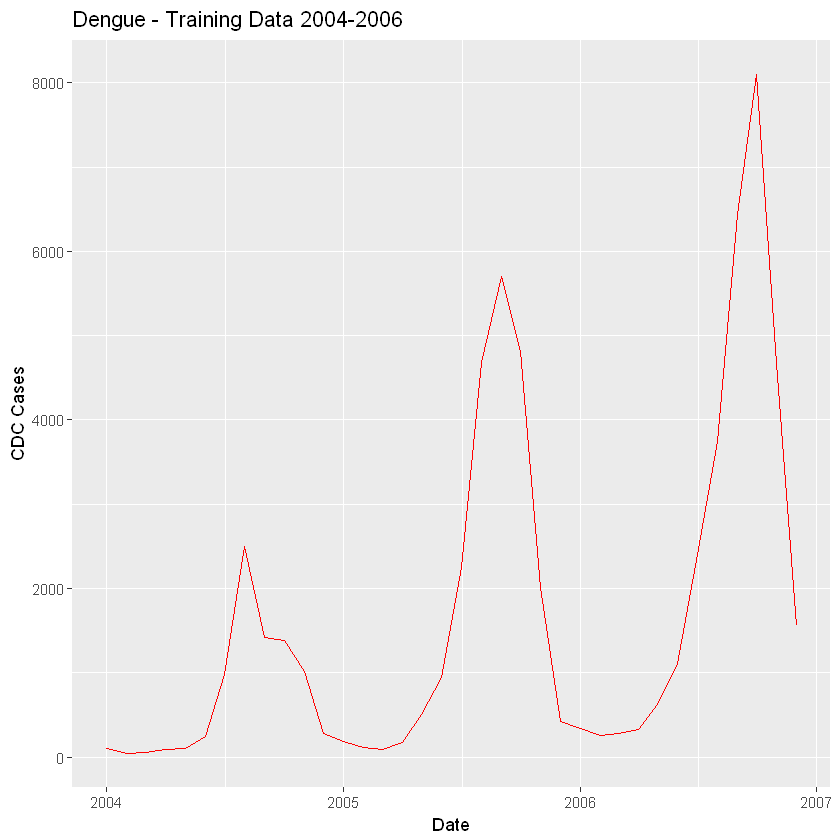

In [85]:
ggplot(dengue_train_0406, aes(Date, Cases, group=1)) + 
    geom_line(col="red") + 
    labs(title="Dengue - Training Data 2004-2006", y="CDC Cases")

## (b) Fit linear regression using OLS

In [86]:
fit <- lm(Cases~Searches, dengue_train_0406)
summary(fit)


Call:
lm(formula = Cases ~ Searches, data = dengue_train_0406)

Residuals:
    Min      1Q  Median      3Q     Max 
-2605.4  -644.1   -92.0   529.8  3190.1 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2155.3      220.6   9.771 2.11e-11 ***
Searches      2926.4      373.2   7.842 3.96e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1269 on 34 degrees of freedom
Multiple R-squared:  0.644,	Adjusted R-squared:  0.6335 
F-statistic: 61.49 on 1 and 34 DF,  p-value: 3.961e-09


## (c) Predict dengue cases from OLS parameters

In [97]:
slope <- summary(fit)$coefficients[2]
intercept <- summary(fit)$coefficients[1]

dengue_pred_0406 <- dengue_train_0406$Searches*slope+intercept
dengue_0406 <- dengue_train_0406
dengue_0406$Pred <- dengue_pred_0406

dengue_0406_long <- melt(dengue_0406, id=c("Date","Searches"))

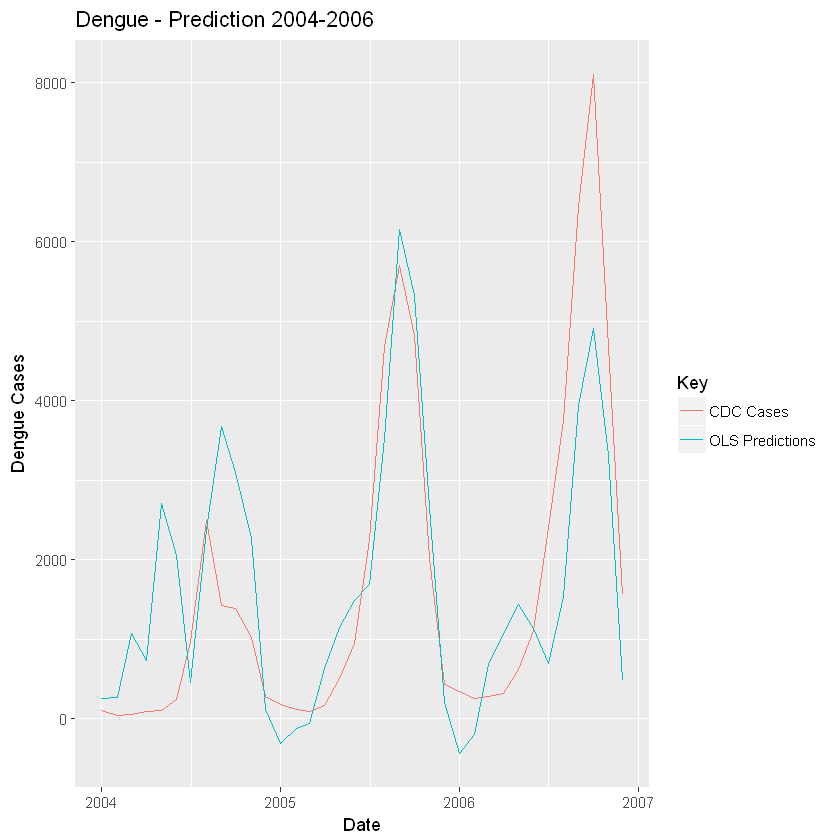

In [117]:
ggplot(dengue_0406_long, aes(Date, value, col=variable)) + 
    geom_line() + 
    labs(title="Dengue - Prediction 2004-2006", y="Dengue Cases", col="Key") +
    scale_color_hue(labels=c("CDC Cases", "OLS Predictions"))

## (d) Predict dengue using OLS - with training set

In [125]:
dengue_0711 <- dengue_data[year(dengue_data$Date) > 2006,]
dengue_pred_0711 <- dengue_0711$Searches*slope+intercept
dengue_0711$Pred <- dengue_pred_0711
dengue_0711_long <- melt(dengue_0711, id=c("Date","Searches"))

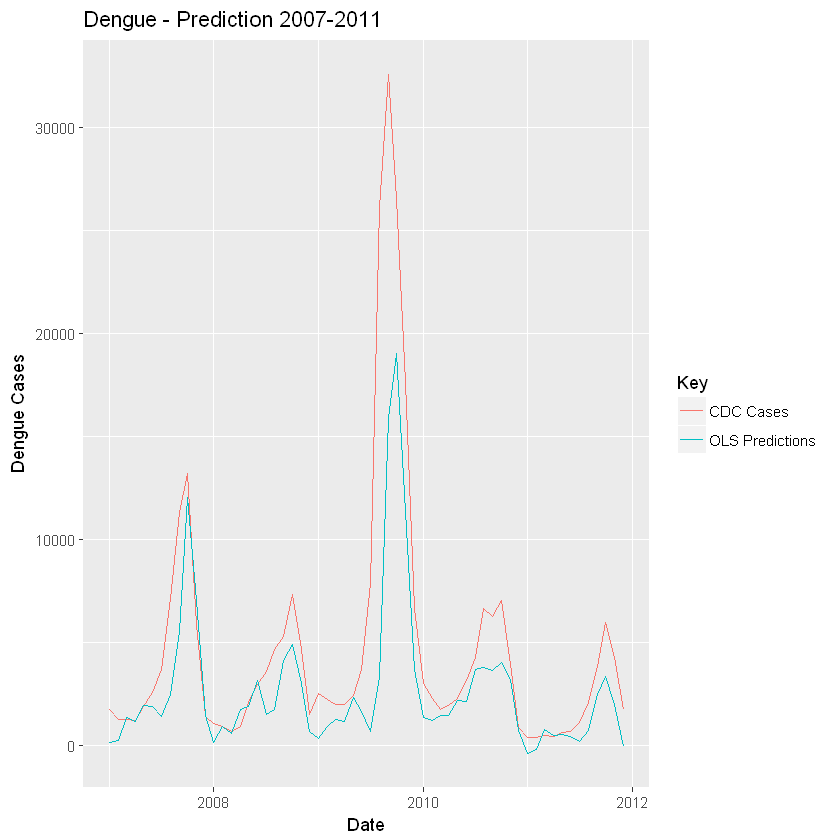

In [126]:
ggplot(dengue_0711_long, aes(Date, value, col=variable)) + 
    geom_line() + 
    labs(title="Dengue - Prediction 2007-2006", y="Dengue Cases", col="Key") +
    scale_color_hue(labels=c("CDC Cases", "OLS Predictions"))

# Dynamic Training 

In [175]:
fitOLS_dynamic <- function(xval, yval){
    int_list <- list()
    slope_list <- list()
    for(i in 1:length(xval)){
        y <- yval[i:length(yval)]
        x <- xval[i:length(xval)]
        ols_fit <- lm(y~x)
        intercept <- summary(ols_fit)$coefficients[1]        
        slope <- summary(ols_fit)$coefficients[2]
        int_list <- rbind(int_list, intercept)
        slope_list <- rbind(slope_list, slope)
    }
    params <- data.frame(int_list, slope_list)
    return(params)
}

In [272]:
params <- fitOLS_dynamic(dengue_data$Searches, dengue_data$Cases)
intercept <- params$int_list
slope <- params$slope_list
names(intercept) <- c()
names(slope) <- c()
dengue_pred <- list()

for(i in 1:nrow(dengue_data)){
    # First two case counts taken as given
    if(i<=2){
        dengue_pred <- rbind(dengue_pred, dengue_data$Cases[i])
    }
    # Use parameters calculated for prior window to predict cases
    if (i>2){
        pred <- dengue_data$Searches[i]*as.numeric(slope[i-1])+as.numeric(intercept[i-1])
        dengue_pred <- rbind(dengue_pred, pred)
    }
}

rownames(dengue_pred) <- c()
dengue_data$Pred <- as.numeric(dengue_pred)
dengue_long <- melt(dengue_data, id=c("Date","Searches"))

Warning message in data.row.names(row.names, rowsi, i):
"some row.names duplicated: 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96 --> row.names NOT used"Warning message in data.row.names(row.names, rowsi, i):
"some row.names duplicated: 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96 --> row.names NOT used"

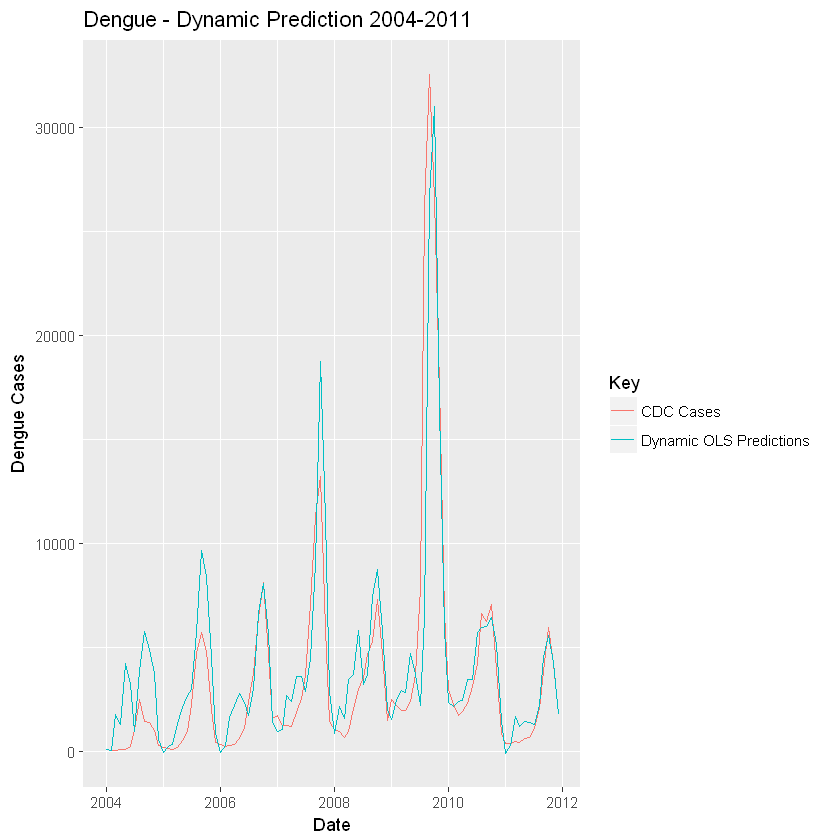

In [276]:
ggplot(dengue_long, aes(Date, value, col=variable)) + 
    geom_line() + 
    labs(title="Dengue - Dynamic Prediction 2004-2011", y="Dengue Cases", col="Key") +
    scale_color_hue(labels=c("CDC Cases", "Dynamic OLS Predictions"))

## Additional Variables

In [629]:
# Load data
dengue_multi <- read.csv("GT_Mexico.csv")

# Fix data
colnames(dengue_multi)[1] <- "Date"
colnames(dengue_multi)[6] <- "sintomas.dl.dengue"
dengue_multi$Date <- as.POSIXct(dengue_multi$Date, format="%Y-%m-%d")
dengue_multi$Year <- year(dengue_multi$Date)
dengue_multi$Month <- month(dengue_multi$Date)

# Transform to long
dengue_multi_long <- melt(dengue_multi, id=c("Date", "Month", "Year"))
colnames(dengue_multi_long)[4] <- "Term"
colnames(dengue_multi_long)[5] <- "Searches"

# Average searches over every given month so as to format according 
# to available CDC case count data:
GB <- dengue_multi_long %>%
        group_by(Month=dengue_multi_long$Month, Year=dengue_multi_long$Year, Term=dengue_multi_long$Term) %>%
        summarize(Average=mean(Searches))

# Format long to wide
GB <- GB %>% spread(Term, Average)

In [630]:
# Load data
dengue_count <- read.csv('CaseCount(Mexico).csv')

# Fix data
dengue_count <- dengue_count[,2:3]
colnames(dengue_count) <- c("Date", "Cases")
dengue_count$Date <- as.POSIXct(paste('1',dengue_count$Date), format="%d %b %Y")
dengue_count$Month <- month(dengue_count$Date)
dengue_count$Year <- year(dengue_count$Date)

In [631]:
# Join CDC counts with Google search data
GB <- GB %>% left_join(. , dengue_count, by=c("Month"="Month", "Year"="Year"))

# Order by date
GB_order <- GB[order(GB$Year, GB$Month),]

In [632]:
# Create training and test sets
GB_train <- GB_order[1:36,]
GB_test <- GB_order[37:148,]

## Static

In [633]:
# Fit a linear regression 
fit <- glm(Cases~.-Month-Year-Date, data=GB_train, family=gaussian())
summary(fit)


Call:
glm(formula = Cases ~ . - Month - Year - Date, family = gaussian(), 
    data = GB_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2330.2   -550.3   -101.3    411.3   2644.4  

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)  
(Intercept)          -754.737    827.233  -0.912   0.3703  
dengue                 26.762    137.836   0.194   0.8476  
dengue.dengue.dengue  291.192    138.441   2.103   0.0457 *
el.dengue            -165.854     64.100  -2.587   0.0159 *
dengue.sintomas       157.069     89.416   1.757   0.0912 .
sintomas.dl.dengue    -25.504     32.918  -0.775   0.4457  
dengue.hemorragico     31.244     30.079   1.039   0.3089  
sintomas.de.dengue    -25.864     24.848  -1.041   0.3079  
que.es.dengue         -38.741     26.346  -1.470   0.1539  
dengue.clasico        -30.924     18.697  -1.654   0.1106  
dengue.mosquito         1.296     23.155   0.056   0.9558  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '

In [634]:
# Construct a prediction using the above linear regression
GB_test$Pred <- predict(fit, GB_test)

In [635]:
# Transform to long
GB_long <- melt(GB_test, id=c("Date", "Month", "Year", "dengue", "dengue.dengue.dengue", 
                               "el.dengue", "dengue.sintomas", "sintomas.dl.dengue",
                               "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", 
                               "dengue.clasico", "dengue.mosquito"))
head(GB_long)

Date,Month,Year,dengue,dengue.dengue.dengue,el.dengue,dengue.sintomas,sintomas.dl.dengue,dengue.hemorragico,sintomas.de.dengue,que.es.dengue,dengue.clasico,dengue.mosquito,variable,value
2007-01-01,1,2007,8.25,8.75,5.25,4.00,6.00,9.00,8.5,11.25,14.25,11.50,Cases,1716
2007-02-01,2,2007,7.00,6.50,6.00,3.75,7.25,6.25,0.0,12.00,10.50,15.25,Cases,1263
2007-03-01,3,2007,13.20,14.60,9.60,7.00,8.60,13.00,9.8,17.80,18.00,13.80,Cases,1238
2007-04-01,4,2007,12.25,13.50,9.25,5.75,8.75,12.25,11.0,18.50,8.50,14.00,Cases,1206
2007-05-01,5,2007,14.25,16.50,12.00,5.50,7.25,9.00,9.0,19.25,14.25,10.25,Cases,1861
2007-06-01,6,2007,17.40,17.40,14.40,5.20,8.60,11.00,8.4,20.40,8.40,15.20,Cases,2550


Warning message:
"Removed 8 rows containing missing values (geom_path)."

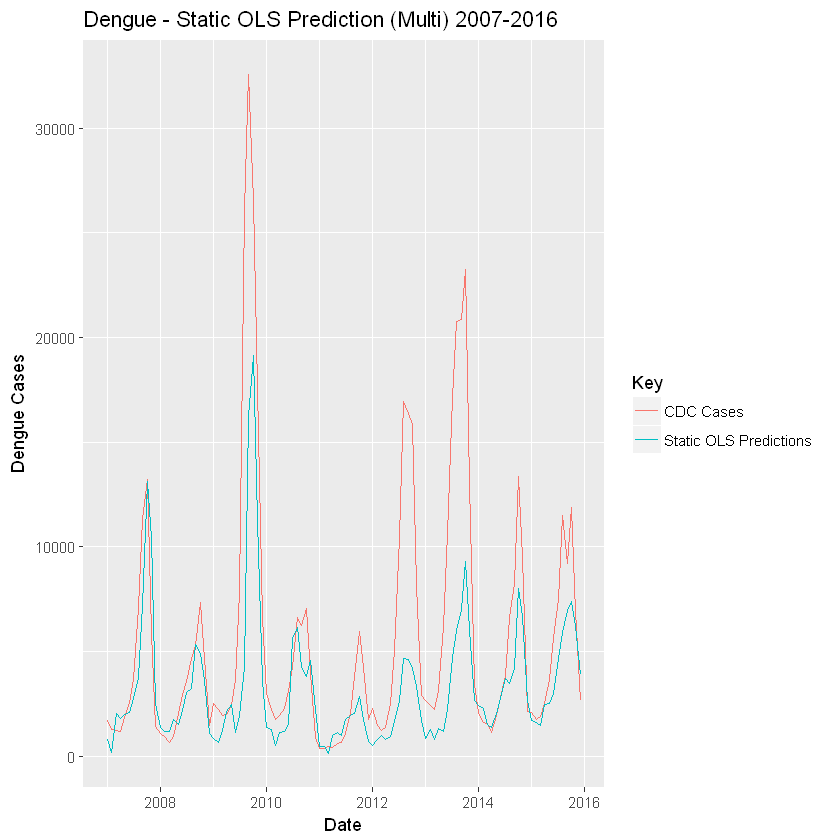

In [636]:
ggplot(GB_long, aes(Date, value, col=variable)) + 
    geom_line() + 
    labs(title="Dengue - Static OLS Prediction (Multi) 2007-2016", y="Dengue Cases", col="Key") +
    scale_color_hue(labels=c("CDC Cases", "Static OLS Predictions"))

## Dynamic

In [643]:
GB_pred <- c()
for(i in 1:nrow(GB_order)){
    # First two case counts taken as given
    if(i<=2){
        GB_pred <- rbind(GB_pred, GB_order$Cases[i])
    }
    # Use parameters calculated for prior window to predict cases
    if (i>2){
        GB_train <- GB_order[1:i-1,]
        fit <- glm(Cases~.-Month-Year-Date, data=GB_train, family=gaussian())
        pred <- predict(fit, GB_order[i,])
        GB_pred <- rbind(GB_pred, pred)
    }
}

rownames(GB_pred) <- c()

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient 

In [646]:
GB_order$Dynamic_Pred <- as.numeric(GB_pred)
GB_long <- melt(GB_order, id=c("Date", "Month", "Year", "dengue", "dengue.dengue.dengue", 
                               "el.dengue", "dengue.sintomas", "sintomas.dl.dengue",
                               "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", 
                               "dengue.clasico", "dengue.mosquito"))
head(GB_long)

Date,Month,Year,dengue,dengue.dengue.dengue,el.dengue,dengue.sintomas,sintomas.dl.dengue,dengue.hemorragico,sintomas.de.dengue,que.es.dengue,dengue.clasico,dengue.mosquito,variable,value
2004-01-01,1,2004,16.00,13.00,24.25,11.75,34.5,37.75,0.00,37.00,0.0,25.00,Cases,98
2004-02-01,2,2004,12.00,12.25,15.25,3.50,21.0,37.00,19.00,46.00,0.0,53.25,Cases,41
2004-03-01,3,2004,16.50,14.25,20.50,0.00,0.0,54.75,27.75,43.50,30.0,50.75,Cases,53
2004-04-01,4,2004,13.75,12.50,14.25,0.00,0.0,50.00,0.00,42.00,0.0,69.50,Cases,92
2004-05-01,5,2004,17.00,20.60,23.60,5.20,9.8,33.60,13.80,46.40,19.0,39.80,Cases,100
2004-06-01,6,2004,20.75,19.50,21.75,6.50,0.0,32.25,0.00,53.75,49.5,56.00,Cases,240


Warning message:
"Removed 8 rows containing missing values (geom_path)."

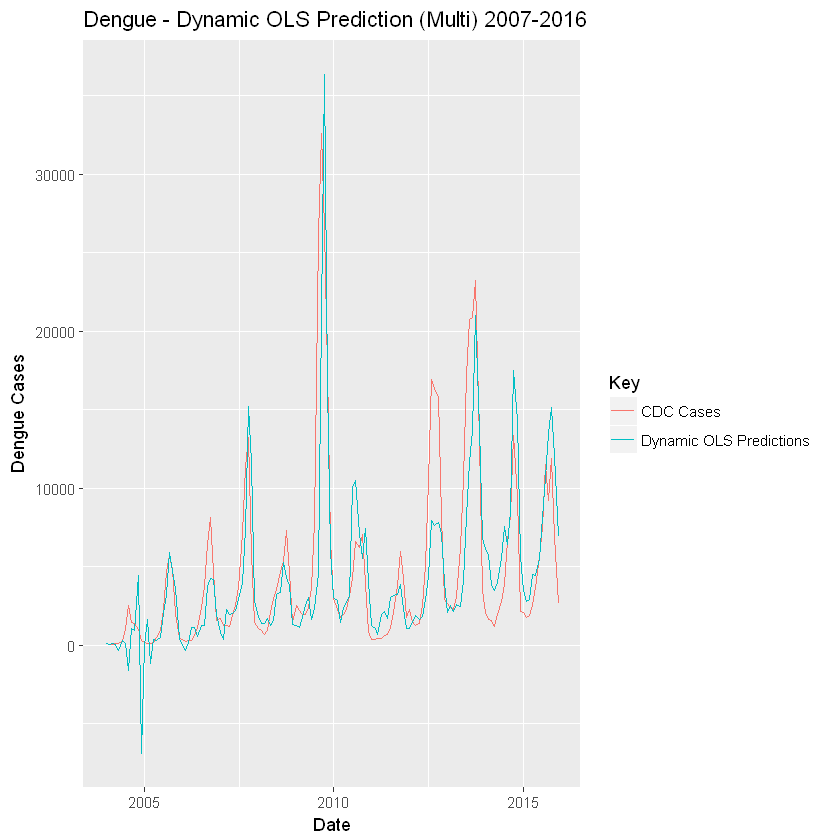

In [647]:
ggplot(GB_long[GB_long$variable!='Pred',], aes(Date, value, col=variable)) + 
    geom_line() + 
    labs(title="Dengue - Dynamic OLS Prediction (Multi) 2007-2016", y="Dengue Cases", col="Key") +
    scale_color_hue(labels=c("CDC Cases", "Dynamic OLS Predictions"))

## Seasonality

In [672]:
# Add column with number of dengue cases in that particular month
# two years prior
GB_seasonality <- GB_order[,1:14]
GB_seasonality$Case_2yr <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i>24){
        GB_seasonality$Case_2yr[i] <- GB_seasonality$Cases[i-24]
    }
    else{
        GB_seasonality$Case_2yr[i] <- GB_seasonality$Cases[i]
    }
}

In [674]:
# Add columns with dengue cases per each month in the prior year
# compared to the month being evaluated

# 1 month
GB_seasonality$Case_1mo <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i>12){
        GB_seasonality$Case_1mo[i] <- GB_seasonality$Cases[i-1]
    }
    else{
        GB_seasonality$Case_1mo[i] <- GB_seasonality$Cases[i]
    }
}

# 2 months
GB_seasonality$Case_2mo <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i>12){
        GB_seasonality$Case_2mo[i] <- GB_seasonality$Cases[i-2]
    }
    else{
        GB_seasonality$Case_2mo[i] <- GB_seasonality$Cases[i]
    }
}

# 3 months
GB_seasonality$Case_3mo <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i>12){
        GB_seasonality$Case_3mo[i] <- GB_seasonality$Cases[i-3]
    }
    else{
        GB_seasonality$Case_3mo[i] <- GB_seasonality$Cases[i]
    }
}

# 4 months
GB_seasonality$Case_4mo <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i>12){
        GB_seasonality$Case_4mo[i] <- GB_seasonality$Cases[i-4]
    }
    else{
        GB_seasonality$Case_4mo[i] <- GB_seasonality$Cases[i]
    }
}

# 5 months
GB_seasonality$Case_5mo <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i>12){
        GB_seasonality$Case_5mo[i] <- GB_seasonality$Cases[i-5]
    }
    else{
        GB_seasonality$Case_5mo[i] <- GB_seasonality$Cases[i]
    }
}

# 6 months
GB_seasonality$Case_6mo <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i>12){
        GB_seasonality$Case_6mo[i] <- GB_seasonality$Cases[i-6]
    }
    else{
        GB_seasonality$Case_6mo[i] <- GB_seasonality$Cases[i]
    }
}

# 7 months
GB_seasonality$Case_7mo <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i>12){
        GB_seasonality$Case_7mo[i] <- GB_seasonality$Cases[i-7]
    }
    else{
        GB_seasonality$Case_7mo[i] <- GB_seasonality$Cases[i]
    }
}

# 8 months
GB_seasonality$Case_8mo <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i>12){
        GB_seasonality$Case_8mo[i] <- GB_seasonality$Cases[i-8]
    }
    else{
        GB_seasonality$Case_8mo[i] <- GB_seasonality$Cases[i]
    }
}

# 9 months
GB_seasonality$Case_9mo <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i>12){
        GB_seasonality$Case_9mo[i] <- GB_seasonality$Cases[i-9]
    }
    else{
        GB_seasonality$Case_9mo[i] <- GB_seasonality$Cases[i]
    }
}

# 10 months
GB_seasonality$Case_10mo <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i>12){
        GB_seasonality$Case_10mo[i] <- GB_seasonality$Cases[i-10]
    }
    else{
        GB_seasonality$Case_10mo[i] <- GB_seasonality$Cases[i]
    }
}

# 11 months
GB_seasonality$Case_11mo <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i>12){
        GB_seasonality$Case_11mo[i] <- GB_seasonality$Cases[i-11]
    }
    else{
        GB_seasonality$Case_11mo[i] <- GB_seasonality$Cases[i]
    }
}

# 12 months
GB_seasonality$Case_12mo <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i>12){
        GB_seasonality$Case_12mo[i] <- GB_seasonality$Cases[i-12]
    }
    else{
        GB_seasonality$Case_12mo[i] <- GB_seasonality$Cases[i]
    }
}

## Static

### Static Lasso (ARGO)

In [1244]:
# Create training and test sets
GB_train <- GB_seasonality[1:36,]
GB_test <- GB_seasonality[37:148,]
#GB_test[is.na(GB_test$Cases),]$Cases <- 0

In [1245]:
# Train model on data from first 36 months
set.seed(1)
folds <- 3
x_train <- model.matrix(Cases~.,GB_train)[,c("dengue", "dengue.dengue.dengue", "el.dengue", "dengue.sintomas", "sintomas.dl.dengue", 
            "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", 
            "Case_2yr", "Case_1mo", "Case_2mo", "Case_3mo",  "Case_11mo", "Case_12mo")]
y_train <- GB_train$Cases
lasso_fit <- cv.glmnet(x_train, y_train, alpha=1, nfolds=folds)
lambda <- lasso_fit$lambda.min

# Test trained model on data from after first 36 months
x_test <- as.matrix(GB_test[,c("dengue", "dengue.dengue.dengue", "el.dengue", "dengue.sintomas", "sintomas.dl.dengue", 
            "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", 
            "Case_2yr", "Case_1mo", "Case_2mo", "Case_3mo",  "Case_11mo", "Case_12mo")])
pred <- predict(lasso_fit$glmnet.fit, s=lambda, newx=x_test)

In [1246]:
GB_seasonality$Predicted_12U24_3yr_lasso_static <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i<=36){
        GB_seasonality$Predicted_12U24_3yr_lasso_static[i] <- GB_seasonality$Cases[i]
    }
    if(i>36){
        GB_seasonality$Predicted_12U24_3yr_lasso_static[i] <- pred[i-36]
    }
}

### Static OLS

In [924]:
# Create training and test sets
GB_train <- GB_seasonality[1:24,]
GB_test <- GB_seasonality[25:148,]
GB_test[is.na(GB_test$Cases),]$Cases <- 0
GB_test[is.na(GB_test$Case_1mo),]$Case_1mo <- 0
GB_test[is.na(GB_test$Case_2mo),]$Case_2mo <- 0
GB_test[is.na(GB_test$Case_3mo),]$Case_3mo <- 0

In [925]:
# Train model on data from first 24 months
set.seed(1)
x_train <- model.matrix(Cases~.,GB_train)[,c("dengue", "dengue.dengue.dengue", "el.dengue", "dengue.sintomas", "sintomas.dl.dengue", 
            "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", 
            "Case_2yr", "Case_1mo", "Case_2mo", "Case_3mo",  "Case_11mo", "Case_12mo")]
y_train <- GB_train$Cases
OLS_fit <- glm(Cases~., data=GB_train[,c("dengue", "dengue.dengue.dengue", "el.dengue", "dengue.sintomas", "sintomas.dl.dengue", 
            "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", "Cases",
            "Case_2yr", "Case_1mo", "Case_2mo", "Case_3mo",  "Case_11mo", "Case_12mo")], family=gaussian())

# Test trained model on data from after first 24 months
static_pred <- predict(OLS_fit, GB_test)

In [926]:
GB_seasonality$static_seasonal_ols <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i<=24){
        GB_seasonality$static_seasonal_ols[i] <- GB_seasonality$Cases[i]
    }
    if(i>24){
        GB_seasonality$static_seasonal_ols[i] <- static_pred[i-24]
    }
}

In [1248]:
GB_seasonality2 <- GB_seasonality[,c("Date", "Month", "Year", "dengue", "dengue.dengue.dengue", "el.dengue", 
                                     "dengue.sintomas", "sintomas.dl.dengue", "dengue.hemorragico", 
                                     "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", 
                                     "Cases", "Predicted_12U24_3yr_lasso_static", "static_seasonal_ols")]

In [1249]:
GB_long <- melt(GB_seasonality2, id=c("Date", "Month", "Year", "dengue", "dengue.dengue.dengue", 
                               "el.dengue", "dengue.sintomas", "sintomas.dl.dengue",
                               "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", 
                               "dengue.clasico", "dengue.mosquito"))
unique(GB_long$variable)

[1] Cases                            Predicted_12U24_3yr_lasso_static
[3] static_seasonal_ols             
Levels: Cases Predicted_12U24_3yr_lasso_static static_seasonal_ols

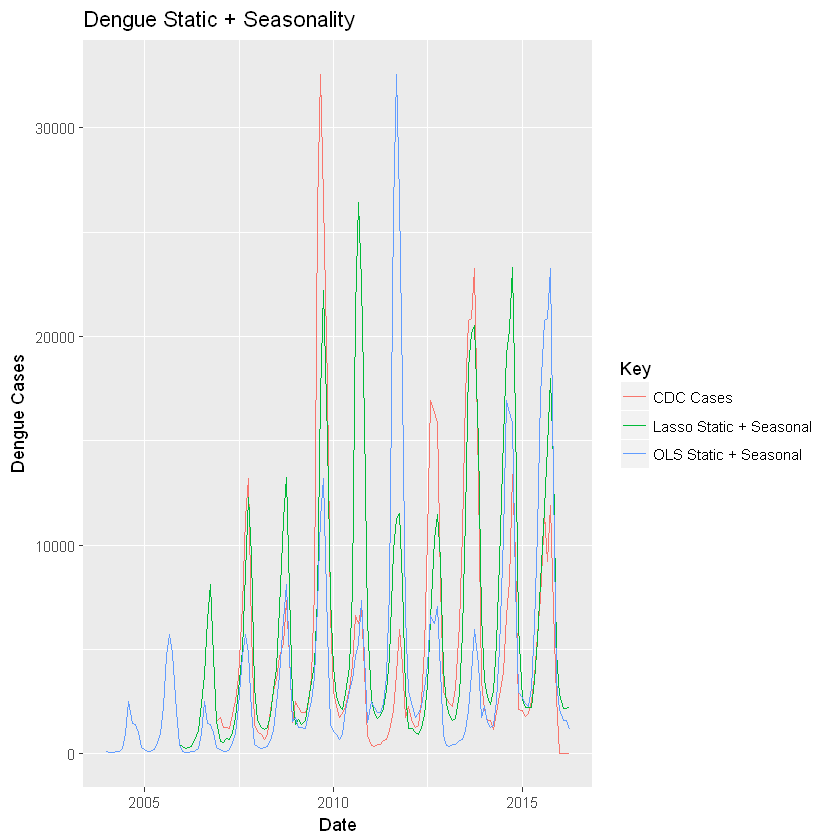

In [1250]:
ggplot(GB_long, aes(Date, value, col=variable)) + geom_line() + 
    labs(title="Dengue Static + Seasonality", y="Dengue Cases", col="Key") +
    scale_color_hue(labels=c("CDC Cases", "Lasso Static + Seasonal", "OLS Static + Seasonal"))

## Dynamic

In [1258]:
# Dynamic using the data from the entire year prior and from the
# particular month 2 years prior OLS (~ARGO):
GB_seasonality$Predicted_12U24 <- 0
#GB_seasonality[is.na(GB_seasonality$Cases),]$Cases <- 0
#GB_seasonality[is.na(GB_seasonality$Case_1mo),]$Case_1mo <- 0
#GB_seasonality[is.na(GB_seasonality$Case_2mo),]$Case_2mo <- 0
#GB_seasonality[is.na(GB_seasonality$Case_3mo),]$Case_3mo <- 0

for(i in 1:nrow(GB_seasonality)){
    if(i<=2){
        GB_seasonality$Predicted_12U24[i] <- GB_seasonality$Cases[i]
    }
    if(i>2){
        # Create training and test sets
        GB_train <- GB_seasonality[1:i-1,c("dengue", "dengue.dengue.dengue", "el.dengue", "dengue.sintomas", "sintomas.dl.dengue", 
            "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", "Cases",
            "Case_2yr", "Case_1mo", "Case_2mo", "Case_3mo", "Case_4mo", "Case_5mo", "Case_6mo", "Case_7mo", "Case_8mo", 
            "Case_9mo", "Case_10mo", "Case_11mo", "Case_12mo")]
        GB_test <- GB_seasonality[i,c("dengue", "dengue.dengue.dengue", "el.dengue", "dengue.sintomas", "sintomas.dl.dengue", 
            "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", "Cases",
            "Case_2yr", "Case_1mo", "Case_2mo", "Case_3mo", "Case_4mo", "Case_5mo", "Case_6mo", "Case_7mo", "Case_8mo", 
            "Case_9mo", "Case_10mo", "Case_11mo", "Case_12mo")]
        # Train model
        dynamic_fit <- glm(Cases~., data=GB_train)
        # Test model
        dynamic_pred <- predict(dynamic_fit, GB_test)                            
        GB_seasonality$Predicted_12U24[i] <- dynamic_pred
    }
}

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient 

In [1259]:
GB_seasonality2 <- GB_seasonality[,c("Date", "Month", "Year", "dengue", "dengue.dengue.dengue", "el.dengue", 
                                     "dengue.sintomas", "sintomas.dl.dengue", "dengue.hemorragico", 
                                     "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", 
                                     "Cases", "Predicted_12U24")]

In [1260]:
GB_long <- melt(GB_seasonality2, id=c("Date", "Month", "Year", "dengue", "dengue.dengue.dengue", 
                               "el.dengue", "dengue.sintomas", "sintomas.dl.dengue",
                               "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", 
                               "dengue.clasico", "dengue.mosquito"))
unique(GB_long$variable)

[1] Cases           Predicted_12U24
Levels: Cases Predicted_12U24

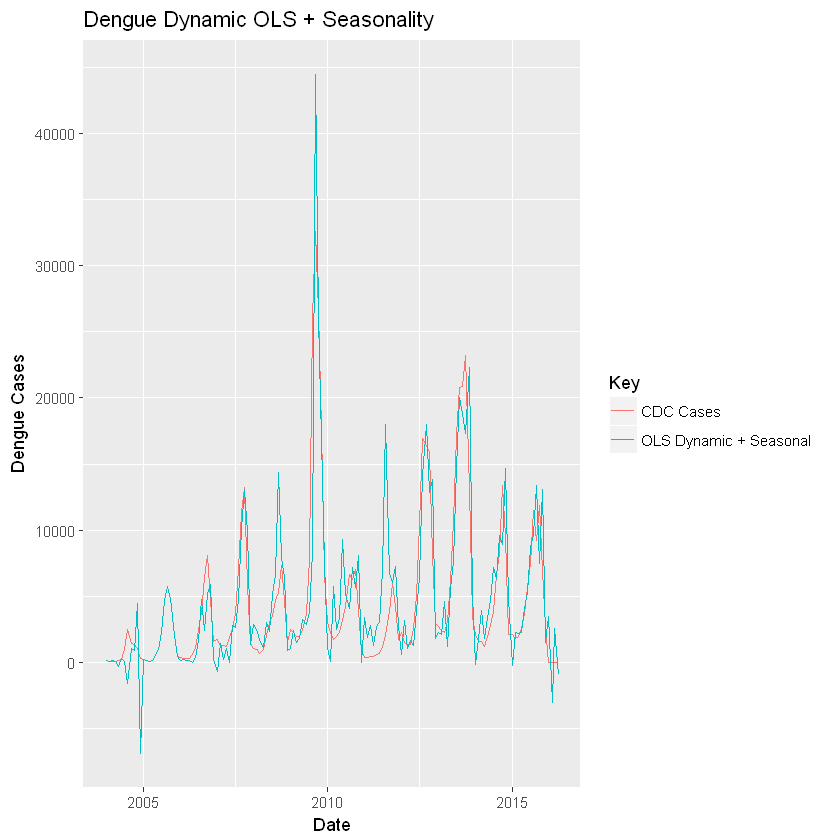

In [1261]:
ggplot(GB_long, aes(Date, value, col=variable)) + geom_line() + 
    labs(title="Dengue Dynamic OLS + Seasonality", y="Dengue Cases", col="Key") +
    scale_color_hue(labels=c("CDC Cases", "OLS Dynamic + Seasonal"))

The attempt to emulate the ARGO model using ols instead of lasso with a 2 yr training period was not succesful (as is evidnet in the graph that follows) since the number of available variables is equal to the number of trianing points which results in a non-unique solution.



In [1060]:
# 2 year training time using the data from the entire year
# prior and from the particular month 2 years prior - ARGO
GB_seasonality$Predicted_12U24_2yr <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i<=24){
        GB_seasonality$Predicted_12U24_2yr[i] <- GB_seasonality$Cases[i]
    }
    if(i>24){
        # Create training and test sets
        GB_train <- GB_seasonality[(i-24):(i-1),c("dengue", "dengue.dengue.dengue", "el.dengue", "dengue.sintomas", "sintomas.dl.dengue", 
            "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", "Cases",
            "Case_2yr", "Case_1mo", "Case_2mo", "Case_3mo", "Case_4mo", "Case_5mo", "Case_6mo", "Case_7mo", "Case_8mo", 
            "Case_9mo", "Case_10mo", "Case_11mo", "Case_12mo")]
        GB_test <- GB_seasonality[i,c("dengue", "dengue.dengue.dengue", "el.dengue", "dengue.sintomas", "sintomas.dl.dengue", 
            "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", "Cases",
            "Case_2yr", "Case_1mo", "Case_2mo", "Case_3mo", "Case_4mo", "Case_5mo", "Case_6mo", "Case_7mo", "Case_8mo", 
            "Case_9mo", "Case_10mo", "Case_11mo", "Case_12mo")]
        # Train model
        dynamic_fit <- glm(Cases~., data=GB_train)
        # Test model
        dynamic_pred <- predict(dynamic_fit, GB_test)                            
        GB_seasonality$Predicted_12U24_2yr[i] <- dynamic_pred
    }
}

In [1063]:
GB_seasonality2 <- GB_seasonality[,c("Date", "Month", "Year", "dengue", "dengue.dengue.dengue", "el.dengue", 
                                     "dengue.sintomas", "sintomas.dl.dengue", "dengue.hemorragico", 
                                     "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", 
                                     "Cases", "Predicted_12U24_2yr")]

Warning message:
"Removed 8 rows containing missing values (geom_path)."

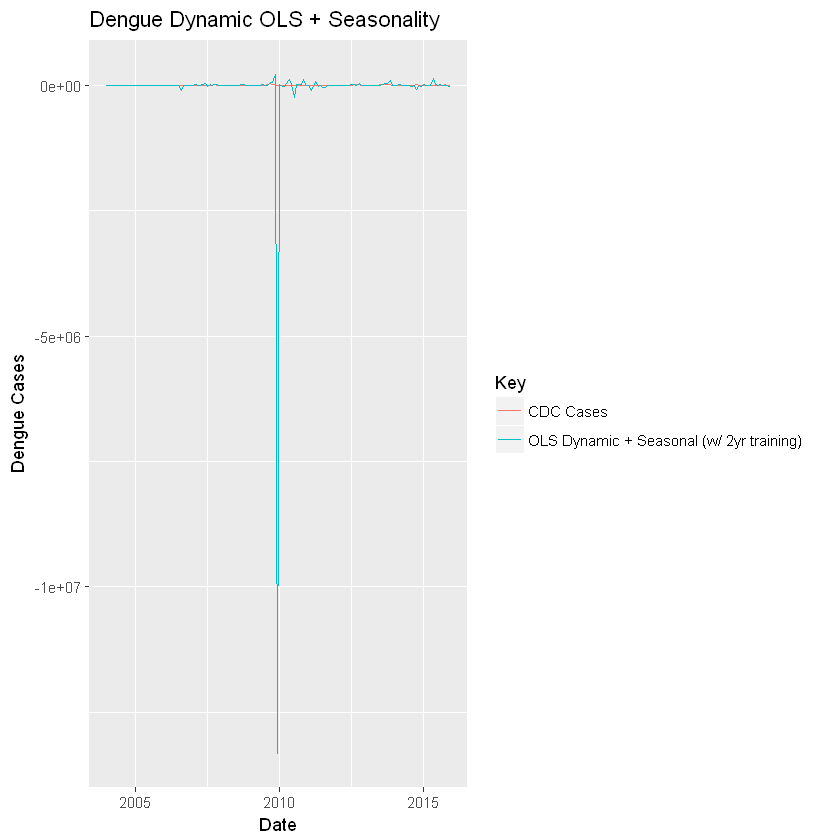

In [1065]:
GB_long <- melt(GB_seasonality2, id=c("Date", "Month", "Year", "dengue", "dengue.dengue.dengue", 
                               "el.dengue", "dengue.sintomas", "sintomas.dl.dengue",
                               "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", 
                               "dengue.clasico", "dengue.mosquito"))
ggplot(GB_long, aes(Date, value, col=variable)) + geom_line() + 
    labs(title="Dengue Dynamic OLS + Seasonality", y="Dengue Cases", col="Key") +
    scale_color_hue(labels=c("CDC Cases", "OLS Dynamic + Seasonal (w/ 2yr training)"))

In [ ]:
#GB_seasonality[145:148,]$Date <- as.POSIXct(paste(GB_seasonality[145:148,]$Month, "1", GB_seasonality[145:148,]$Year), format="%m %d %Y")

In [1251]:
# ARGO (dynamic, 3 yr training window, multi + seasonal)
folds = 3
GB_seasonality$Predicted_12U24_3yrlasso <- 0
for(i in 1:nrow(GB_seasonality)){
    if(i<=36){
        GB_seasonality$Predicted_12U24_3yrlasso[i] <- GB_seasonality$Cases[i]
    }
    if(i>36){
        # Create training and test sets
        GB_train <- GB_seasonality[(i-36):(i-1),]
        GB_test <- GB_seasonality[i,]
        # Train model on data from first 36 months
        set.seed(1)
        folds <- 3
        x_train <- model.matrix(Cases~.,GB_train)[,c("dengue", "dengue.dengue.dengue", "el.dengue", "dengue.sintomas", "sintomas.dl.dengue", 
                    "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", 
                    "Case_2yr", "Case_1mo", "Case_2mo", "Case_3mo",  "Case_11mo", "Case_12mo")]
        y_train <- GB_train$Cases
        lasso_fit <- cv.glmnet(x_train, y_train, alpha=1, nfolds=folds)
        lambda <- lasso_fit$lambda.min
        # Test trained model on data from after first 36 months
        x_test <- as.matrix(GB_test[,c("dengue", "dengue.dengue.dengue", "el.dengue", "dengue.sintomas", "sintomas.dl.dengue", 
                    "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", 
                    "Case_2yr", "Case_1mo", "Case_2mo", "Case_3mo",  "Case_11mo", "Case_12mo")])
        dynamic_lasso_pred <- predict(lasso_fit$glmnet.fit, s=lambda, newx=x_test)
        GB_seasonality$Predicted_12U24_3yrlasso[i] <- dynamic_lasso_pred
    }
}

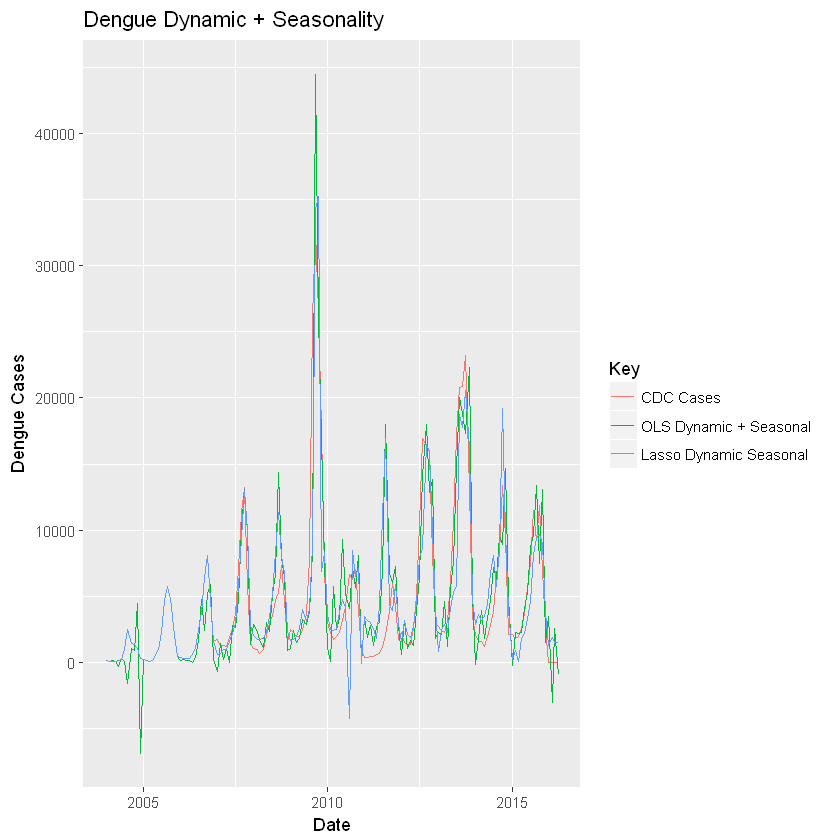

In [1257]:
GB_seasonality2 <- GB_seasonality[,c("Date", "Month", "Year", "dengue", "dengue.dengue.dengue", "el.dengue", 
                                     "dengue.sintomas", "sintomas.dl.dengue", "dengue.hemorragico", 
                                     "sintomas.de.dengue", "que.es.dengue", "dengue.clasico", "dengue.mosquito", 
                                     "Cases", "Predicted_12U24", "Predicted_12U24_3yrlasso")]
GB_long <- melt(GB_seasonality2, id=c("Date", "Month", "Year", "dengue", "dengue.dengue.dengue", 
                               "el.dengue", "dengue.sintomas", "sintomas.dl.dengue",
                               "dengue.hemorragico", "sintomas.de.dengue", "que.es.dengue", 
                               "dengue.clasico", "dengue.mosquito"))
ggplot(GB_long, aes(Date, value, col=variable)) + geom_line() + 
    labs(title="Dengue Dynamic + Seasonality", y="Dengue Cases", col="Key") +    
    scale_color_hue(labels=c("CDC Cases", "OLS Dynamic + Seasonal", "Lasso Dynamic Seasonal"))